# **6.047 | 6.878 | HST.507**

#**Fall 2021 Problem Set 4: Alleles and Arrays**

Due: Monday, November 8 at 11:59PM (submit copy of notebook to Stellar)

#Load libraries


In [2]:
from google.colab import files
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Finding eQTLs

In this problem, we will examine the sources of variation in gene expression that partition a population into subpopulations.

You will need to download the following [files](https://www.dropbox.com/sh/csmgittpy4ub15t/AABnqBgWYKwiFzUVPCpTPE_Qa?dl=0) and upload them to colab using the following code block.

In [4]:
eQTLs = files.upload()

Saving ExpData.txt to ExpData (1).txt
Saving SnpData.txt to SnpData.txt


You are free to use the following function to help you process the raw `ExpData.txt` and `SnpData.txt` files.

In [5]:
# Processes *Data.txt files
"""
Example inp:
    Patient Trait1 Trait2 Trait3
    A 0.1 0.2 0.3
    B 0.4 0.5 0.6
    C 0.7 0.8 0.9

process_file(inp, "patient")
    [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]]

process_file(inp, "trait")
    {"Trait1": [0.1, 0.4, 0.7], "Trait2": [0.2, 0.5, 0.8], "Trait3": [0.3, 0.6, 0.9]}
"""
def process_file(inp, mode):
    rows = inp.decode("utf-8").split("\n")
    if mode == "patient":
        return [[float(val) for val in row.split()[1:]] for row in rows[1:] if row]
    elif mode == "trait":
        res = pd.DataFrame([row.split()[1:] for row in rows if row])
        res.columns = res.iloc[0]
        return {k: [float(val) for val in v.values()] for k, v in res[1:].to_dict().items()}

snp_patient=process_file(eQTLs["SnpData.txt"], "patient")
snp_trait=process_file(eQTLs["SnpData.txt"], "trait")
exp_patient=process_file(eQTLs["ExpData.txt"], "patient")
exp_trait=process_file(eQTLs["ExpData.txt"], "trait")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: DataFrame columns are not unique, some columns will be omitted.


Use the following code block if you would like to process the raw `ExpData.txt` and `SnpData.txt` files in your own way.

In [93]:
print(snp_patient[0][:5])
print(snp_trait['SNP_1'][:5])
print(exp_patient[0][:5])
print(exp_trait['Gene_RTH04'][:5])

[0.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 2.0, 1.0, 0.0, 1.0]
[0.101569595067263, 0.436268619671374, -1.47429429012199, -0.900022560210903, 0.404890736265597]
[0.101569595067263, -1.0120791077431, 1.27888075934562, -0.0907698240983281, 1.04783630384051]


A) The `ExpData.txt` file contains log-normalized RNA-seq expression data from our population of 1,000 samples, with 5,000 genes profiled for each sample. Do a principal components analysis on this dataset to find the clusters of samples that have similar patterns of gene expression. Plot the output of your analysis.
In your plots, be sure the axes are labeled with the components you are displaying in each plot. Also make sure that at least one of your plots colours the points corresponding to the samples with the sub-population that you think they should belong to. (Hint: You can re-use your $k$-means code from PSET 3 to find these sub-populations!)

Describe the patterns that you observe. What is the structure inherent in this population?

You may find the `matplotlib.pyplot` and `sklearn.decomposition.PCA` packages (already imported) to be useful.

Optimal Clustering:


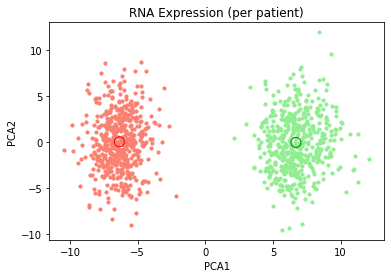

In [6]:
def assignPoints(tbl, ctrs):
    """Assign each of the points in tbl to the cluster with center in ctrs"""

    ptsAsgn = []
    
    for pt in tbl:
      dist=float('inf')
      c=None
      for center in ctrs:
        new=(((center[0]-pt[0])**2)+((center[1]-pt[1])**2))**(1/2)
        if new<dist:
          dist=new
          c=center
      ptsAsgn.append(c)

    return ptsAsgn

def recalculateCtrs(tbl, ctrs, ptsAsgn):
    """Update the centroids based on the points assigned to them"""

    newCtrs = []
    for center in ctrs:
      coord=[0,0]
      num=0
      for i in range(len(tbl)):
        if ptsAsgn[i]==center:
          coord[0]+=tbl[i][0]
          coord[1]+=tbl[i][1]
          num+=1
      if num!=0:
        coord=[i/num for i in coord]
        newCtrs.append(coord)

    return newCtrs

def run_kmeans(dataTable, title, x,y):
    run_results=[[],[],[]]
    for i in range(10):
      """initializes centroids, stop criterion and step counting for clustering"""
      newCtrs = random.sample(dataTable,k=2)
      ptMemb = assignPoints(dataTable, newCtrs)
      stopCrit = False
      stepCount = 0

      """performs k-means clustering, plotting the clusters at each step"""
      while not stopCrit:
          stepCount+=1
          oldCtrs=newCtrs
          newCtrs=recalculateCtrs(dataTable, newCtrs, ptMemb)
          ptMemb=assignPoints(dataTable,newCtrs)

          """stop criterion - when centroids' total movement after a step is below
              the threshold, stop the algorithm"""
          stopDist = 0;
          for i in range(len(newCtrs)):
              stopDist += np.linalg.norm(np.array(oldCtrs[i]) - np.array(newCtrs[i]))
          if stopDist < 5:
              stopCrit = True

      avg_dist=0
      for ctr in newCtrs:
        dist=0
        num=0
        for i in range(len(dataTable)):
          if ptMemb[i]==ctr:
            num+=1
            dist+=((dataTable[i][0]-ctr[0])**2+(dataTable[i][1]-ctr[1])**2)**(1/2)
        avg_dist+=(dist/num)
      run_results[0].append(avg_dist)
      run_results[1].append(ptMemb)
      run_results[2].append(newCtrs)
    
    index=run_results[0].index(min(run_results[0]))
    print('Optimal Clustering:')
    plotClusters(dataTable, run_results[1][index], run_results[2][index], title, x, y)

    membership={'cluster1': [], 'cluster2': []}
    c1=run_results[1][index][0]
    for i in range(len(dataTable)):
      if run_results[1][index][i]==c1:
        membership['cluster1'].append(i)
      else:
        membership['cluster2'].append(i)
    return membership

def plotClusters(tbl, ptMemb, cntrs, title, x, y):
    """Generate a scatterplot of the current k-means cluster assignments"""

    pt_colors = ["salmon", "lightgreen", "lightblue",'pink','gray']
    ctr_colors = ["red", "green", "blue",'hotpink','black']
    for i in range(len(cntrs)):
        pts = [tbl[j] for j in range(len(tbl)) if ptMemb[j] == cntrs[i]]
        plt.scatter([pt[0] for pt in pts], [pt[1] for pt in pts], color = pt_colors[i], s = 10)
        plt.scatter([cntrs[i][0]], [cntrs[i][1]], color = ctr_colors[i], s = 100, facecolors = "none")
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

pca=PCA(n_components=2)
pc_exp_patient=[list(i) for i in pca.fit_transform(exp_patient)]
members=run_kmeans(pc_exp_patient, 'RNA Expression (per patient)', 'PCA1', 'PCA2')


The population is partitioned into two subpopulations, separated by PCA1.

B) The `SnpData.txt` file contains genotyping data for the same 1,000 samples across 500 SNPs. Each SNP's genotype has been called with reference to the same reference genotype; "0" thus represents the reference allele, "2" represents the non-reference allele, and "1" represents a different allele on each strand.

You will find that some of the SNPs (more than 5, less than 100) are eQTLs, that is, they have an effect on the expression of one or more of the genes we collected expression data for. Using whatever model you see fit, search for these eQTLs using the genotyping data and the expression data. **You may not have the computational resources to test all combinations of SNPs and genes, so you should think about smart ways to choose subsets of each to find some eQTLs - you don't have to find all of them!**

For three of the eQTLs you found, present the evidence you have for why you think it is an eQTL, and not just associated with the expression of a gene by chance alone. *Be sure to include plots in your analysis to support your hypothesis, and to thoroughly explain the method you used to find eQTLs.* You can assume that the association between genotype and expression is linear for eQTLs. *Don't forget that you should be correcting for the fact that you are performing multiple significance tests.*

In [7]:
snp_t2=[]
for snp in snp_trait:
  number=np.mean(np.array(snp_trait[snp])/2)
  if number>0.01 or (number<0.5 and (1-number)>0.01):
    snp_t2.append(snp)

exp_t2=[]
for gene in exp_trait:
  if np.sum(np.array(exp_trait[gene]))/1000>0.5:
    exp_t2.append(gene)

print(len(snp_t2),len(exp_t2))
bonferroni=0.05/(len(snp_t2)*len(exp_t2))

res={}
for snp in snp_t2:
  for gene in exp_t2:
    X=np.array(snp_trait[snp])
    Y=np.array(exp_trait[gene])
    X=sm.add_constant(X)
    reg=sm.OLS(Y,X).fit()
    if reg.pvalues[1]<bonferroni and reg.f_pvalue<bonferroni:
      res.setdefault(snp,[]).append((gene,reg.rsquared,reg.params))
print(len(res))

500 71
14


Text(0.5, 0.98, 'Predicted eQTLs')

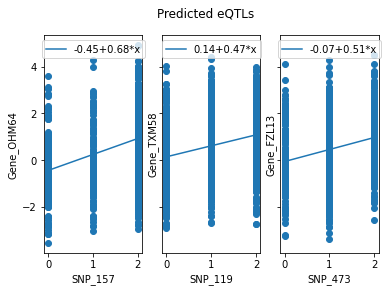

In [8]:
L=[]
for snp in res:
  l=res[snp]
  l.sort(reverse=True, key=lambda x: x[1])
  gene,rsquared,params=l[0]
  L.append((snp,gene,rsquared,params))

L.sort(reverse=True,key=lambda x: x[2])

fig,axes=plt.subplots(1,3, sharey=True)
x=np.array([0,1,2])
for i in range(3):
  axes[i].scatter(snp_trait[L[i][0]],exp_trait[L[i][1]])
  axes[i].plot(x,L[i][3][0]+L[i][3][1]*x, label=str(round(L[i][3][0],2))+"+"+str(round(L[i][3][1],2))+"*x")
  axes[i].set_xlabel(L[i][0])
  axes[i].set_ylabel(L[i][1])
  axes[i].legend(loc='upper center')

fig.suptitle('Predicted eQTLs')

**Answer here:**

eQTL 1: SNP 157

eQTL 2: SNP 119

eQTL 3: SNP 473

I filtered the SNPs by MAF first, which did not end up removing any SNPs.
I then filtered the genes by expression level, keeping genes with an average log expression over 0.5. I used the Bonferroni Correction to reset the p-value threshold based on the total number of SNP-gene comparisons, then ran a linear regression comparing each SNP to each gene, using the p-value of the slope and the F-test p-value to select SNP-gene pairs to keep. I selected the top three SNP-gene pairs based on R^2 values, then plotted them along with their linear regression lines.

C) In the above analysis, we were forced to consider all pairs of SNPs and genes to identify eQTLs. What sources of data that have not been provided as part of this problem would have been useful in constraining the amount of such pairs you had to test? For at least two sources:

i. Give a description of what the dataset would look like (i.e. what are the rows and columns of the data matrix? what kinds of values are stored in the matrix?).

ii. Explain how you would use it to filter out pairs of SNPs and genes that are unlikely to be associated with one another.

Source 1: SNP-Gene proximity

i. A matrix could consist of rows of SNPs and columns of each gene and a set of 0s/1s or True/False within a certain genomic distance of the row-SNP: e.g. row 1 corresponds to SNP 1 and has "True" in each column within a million bp from  SNP1; similarly there could be some kind of distance metric where closer genes have smaller values and further genes have larger values.

ii. Cis- and trans-eQTLs have different strengths of gene regulation, thus it may useful to control for the distance from the gene influenced, so that trans-eQTLs are not by design excluded from consideration. Similarly, closer genes should meet a higher threshold of effect, due to proximity.

Source 2: Housekeeping gene expression

i. This matrix could consist of rows of housekeeping genes and columns of expression data per patient. 

ii. These genes would be filtered from the exp_trait data table. The average variance would also be used to eliminate genes, since any variance in gene expression under the variance of housekeeping genes does not display a significant change.